In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

Mounted at /content/drive


In [2]:
import pandas as pd

# Assuming your file is in Excel format, use read_excel
data = pd.read_csv('/content/drive/MyDrive/climate/minimum1.csv')
data.head()



,Station,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec,Year
0,38,12.2,16.9,21.5,23.2,24.6,26.2,26.7,26.5,26.3,24.9,19.2,15.0,21.93
1,126,10.1,14.2,19.6,21.7,23.5,25.9,26.3,26.3,26.0,24.4,17.5,13.3,19.65
2,87,10.7,15.3,19.7,21.8,23.5,25.9,26.1,26.2,26.1,24.4,17.0,13.6,20.86
3,46,10.6,15.0,19.9,22.2,24.3,26.0,26.4,26.3,26.2,25.1,18.3,14.2,21.21
4,81,10.7,14.7,19.4,22.1,24.3,25.9,26.1,26.0,26.1,24.5,18.1,14.3,21.02


In [3]:
X = data.drop(['Year'], axis=1)
y = data['Year']

# Display the modified feature dataset
print(X)

# Display the target dataset
print(y)



     Station   Jan   Feb   Mar   Apr   May  June  July   Aug   Sep   Oct  \
0         38  12.2  16.9  21.5  23.2  24.6  26.2  26.7  26.5  26.3  24.9   
1        126  10.1  14.2  19.6  21.7  23.5  25.9  26.3  26.3  26.0  24.4   
2         87  10.7  15.3  19.7  21.8  23.5  25.9  26.1  26.2  26.1  24.4   
3         46  10.6  15.0  19.9  22.2  24.3  26.0  26.4  26.3  26.2  25.1   
4         81  10.7  14.7  19.4  22.1  24.3  25.9  26.1  26.0  26.1  24.5   
..       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
421       90  12.7  15.2  19.0  21.7  23.3  25.6  26.5  26.6  26.1  24.0   
422       96  10.1  12.3  17.2  20.7  22.7  25.2  26.3  26.3  25.4  22.6   
423        4  11.5  16.2  20.0  22.2  24.3  26.2  26.4  26.3  24.9  20.1   
424       41  10.8  13.5  17.7  20.8  22.8  25.4  26.6  26.7  25.7  22.6   
425       72  12.0  14.8  20.2  23.4  24.5  26.2  26.5  26.7  26.3  24.1   

      Nov   Dec  
0    19.2  15.0  
1    17.5  13.3  
2    17.0  13.6  
3    18.3  14.2

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define Huber loss function
def huber_loss(delta=1.0):
    def loss(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= delta
        return tf.where(is_small_error,
                        0.5 * tf.square(error),
                        delta * (tf.abs(error) - 0.5 * delta))
    return loss

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (convert to numpy array before reshaping)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Flatten to 1D
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Build an improved ANN model with more hidden layers and regularization
model = Sequential()

# Input Layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden Layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Dropout to reduce overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='linear'))

# Compile the model with the Huber loss function
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=huber_loss(delta=1.0), metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=300, batch_size=16, validation_split=0.2, verbose=1)

# Predictions and inverse scaling
ann_pred_scaled = model.predict(X_test_scaled)
ann_pred = scaler_y.inverse_transform(ann_pred_scaled)  # This returns a 2D array

# Flatten the predictions to ensure they are 1D
ann_pred = ann_pred.flatten()

# Performance evaluation for the ANN model
mae = mean_absolute_error(y_test, ann_pred)
mse = mean_squared_error(y_test, ann_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, ann_pred)
rmsle = np.sqrt(np.mean((np.log1p(ann_pred) - np.log1p(y_test)) ** 2))  # Corrected RMSLE calculation
mape = np.mean(np.abs((y_test - ann_pred) / y_test)) * 100

print(f"\nImproved ANN Model with Huber Loss:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Combine predictions with Huber Regressor
# Assuming `huber_pred` is already calculated from your earlier code
# You may want to recalculate huber_pred here if needed
# For example:
huber_reg = HuberRegressor(epsilon=1.35)
huber_reg.fit(X_train, y_train)
huber_pred = huber_reg.predict(X_test)

# Weight optimization for predictions
weight = 0.5  # Set your optimal weight value based on previous evaluations
ensemble_pred = (weight * huber_pred) + ((1 - weight) * ann_pred)

# Performance evaluation for the ensemble model
mae_ensemble = mean_absolute_error(y_test, ensemble_pred)
mse_ensemble = mean_squared_error(y_test, ensemble_pred)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_ensemble = r2_score(y_test, ensemble_pred)
rmsle_ensemble = np.sqrt(np.mean((np.log1p(ensemble_pred) - np.log1p(y_test)) ** 2))  # Corrected RMSLE calculation
mape_ensemble = np.mean(np.abs((y_test - ensemble_pred) / y_test)) * 100

print(f"\nEnsemble Model (Huber Regressor + ANN) with Weight {weight:.2f}:")
print(f"Mean Absolute Error (MAE): {mae_ensemble:.2f}")
print(f"Mean Squared Error (MSE): {mse_ensemble:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ensemble:.2f}")
print(f"R-squared (R2): {r2_ensemble:.2f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_ensemble:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ensemble:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4887 - mae: 0.7609 - val_loss: 0.0760 - val_mae: 0.3224
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2080 - mae: 0.4459 - val_loss: 0.0714 - val_mae: 0.3142
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1812 - mae: 0.3990 - val_loss: 0.0687 - val_mae: 0.3046
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2159 - mae: 0.4183 - val_loss: 0.0666 - val_mae: 0.2958
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2099 - mae: 0.4161 - val_loss: 0.0647 - val_mae: 0.2859
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1138 - mae: 0.3088 - val_loss: 0.0641 - val_mae: 0.2799
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1732 - mae: 0.3708 - val_loss: 0.0642 - val_mae: 0.2797
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1393 - mae: 0.3492 - val_loss: 0.0664 - val_mae: 0.2856
Epoch 9/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.11

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor

# Load the new dataset for 2023
test_data = pd.read_csv('/content/drive/MyDrive/climate/up_minimum_23.csv')
print(test_data.head())  # Check the structure of the test data

# Prepare the features (use all columns except 'Year')
X_test_2023 = test_data.drop(['Year'], axis=1)  # Drop 'Year' for features
y_test_2023 = test_data['Year']  # Keep 'Year' as the target

# Scale the features using the same scaler as before
scaler_X = StandardScaler()
X_test_2023_scaled = scaler_X.fit_transform(X_test_2023)

# Make predictions using the trained ANN model
ann_pred_2023_scaled = model.predict(X_test_2023_scaled)
ann_pred_2023 = scaler_y.inverse_transform(ann_pred_2023_scaled).flatten()  # Inverse scaling and flattening

# Make predictions using the Huber Regressor
huber_reg = HuberRegressor(epsilon=1.35)
huber_reg.fit(X_train, y_train)  # Ensure Huber is trained with the same training set
huber_pred_2023 = huber_reg.predict(X_test_2023)  # Predicting using the Huber Regressor

# Weight optimization for predictions
weight = 0.5  # Adjust this weight based on your evaluation
ensemble_pred = (weight * huber_pred_2023) + ((1 - weight) * ann_pred_2023)

# Add the ensemble predictions to the test data
test_data['Predicted Value'] = ensemble_pred

# Save the results to a new CSV file
output_file_path = '/content/drive/MyDrive/climate/predicted_minimum_2023.csv'
test_data.to_csv(output_file_path, index=False)

print(f"Ensemble predictions saved to {output_file_path}")


   Station   Jan   Feb   Mar   Apr   May  June  July   Aug   Sep   Oct   Nov  \
0        9  13.5  16.6  21.3  24.1  25.1  26.3  26.5  26.5  26.1  24.2  19.7   
1       37  11.3  14.4  19.1  22.8  24.0  25.6  26.0  26.1  25.7  23.4  18.2   
2       25  11.9  15.1  19.2  22.4  24.0  25.8  26.4  26.5  26.0  23.5  18.1   
3       12  12.1  15.2  20.0  23.6  24.8  26.0  26.2  26.4  26.1  24.1  19.2   
4       23  12.1  15.3  20.1  23.6  24.8  26.0  26.3  26.4  26.1  24.1  19.2   

    Dec       Year  
0  15.5  22.116667  
1  13.6  20.850000  
2  13.8  21.058333  
3  14.5  21.516667  
4  14.3  21.525000  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Ensemble predictions saved to /content/drive/MyDrive/climate/predicted_minimum_2023.csv


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


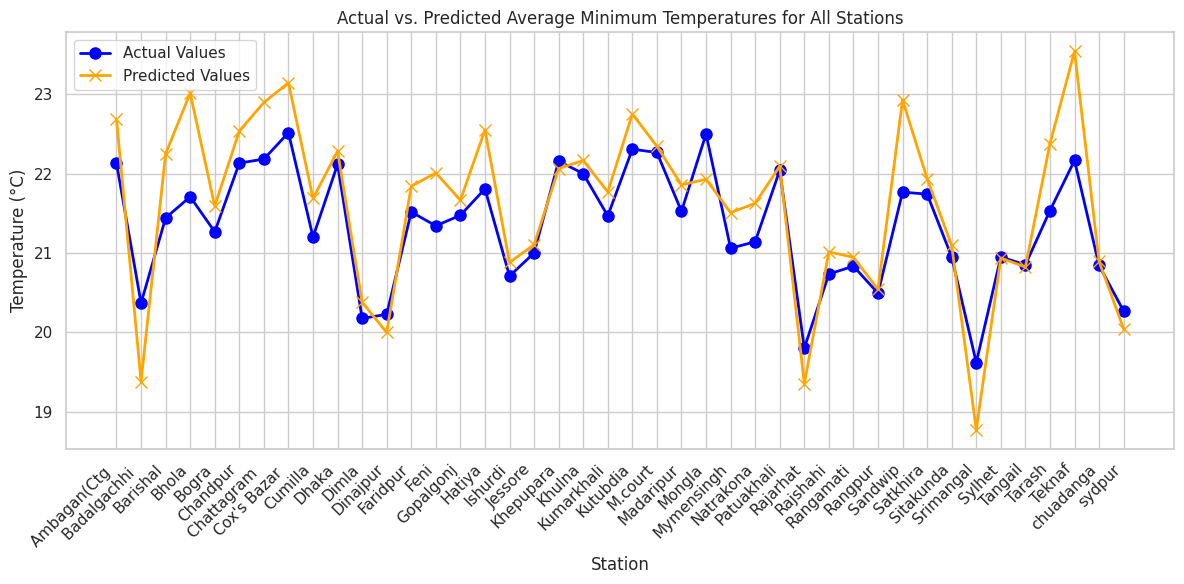

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the predicted results CSV file
predicted_data = pd.read_csv('/content/drive/MyDrive/climate/pre_minimum_23.csv')

# Set the style of seaborn
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Sort the data by station if needed (optional, depending on station order)
predicted_data = predicted_data.sort_values('Station')

# Plot actual values for all stations
plt.plot(predicted_data['Station'], predicted_data['Year'],
         label='Actual Values', marker='o', color='blue', linewidth=2, markersize=8)

# Plot predicted values for all stations
plt.plot(predicted_data['Station'], predicted_data['Predicted Value'],
         label='Predicted Values', marker='x', color='orange', linewidth=2, markersize=8)

# Adding titles and labels
plt.title('Actual vs. Predicted Average Minimum Temperatures for All Stations')
plt.xlabel('Station')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45, ha='right')  # Ensure stations are properly spaced
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


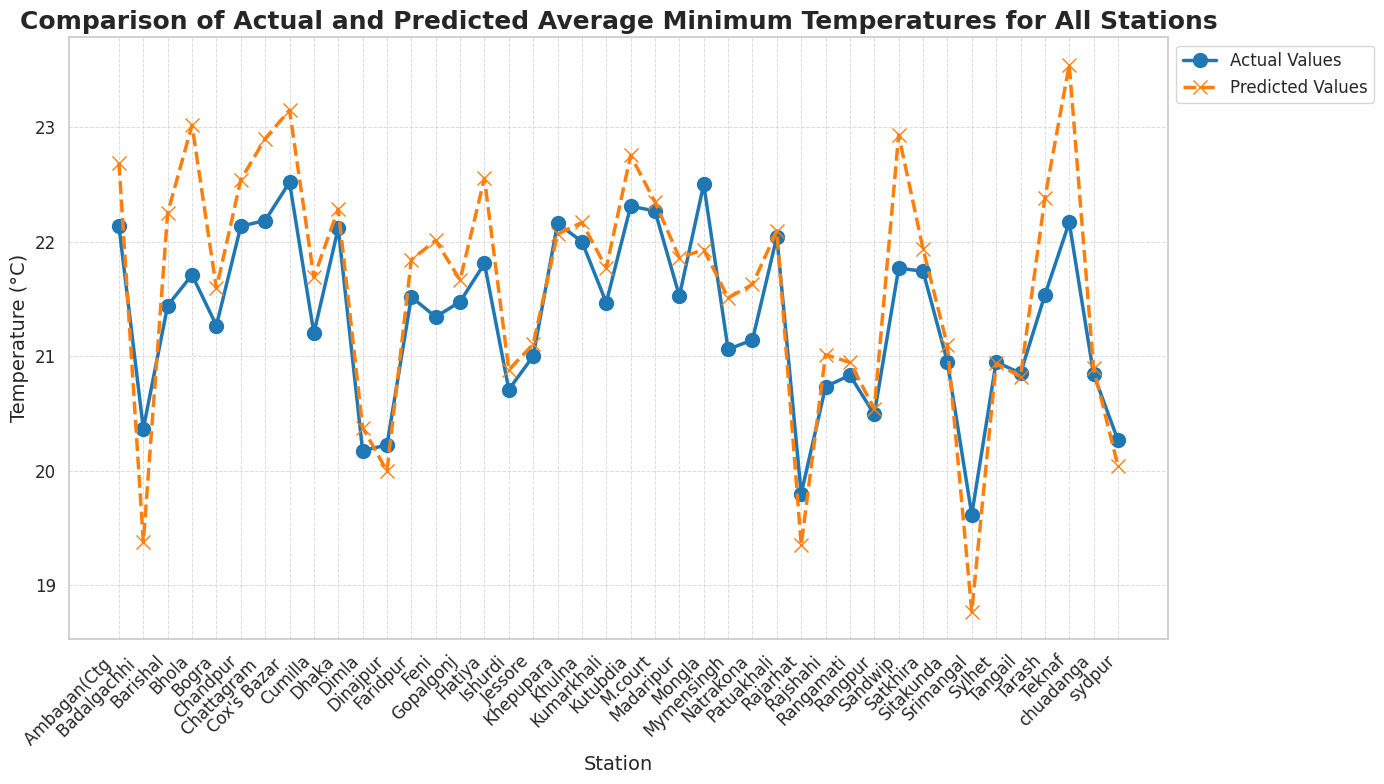

In [11]:
# Save the plot as a high-resolution PDF file for journal paper submission

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the predicted results CSV file
predicted_data = pd.read_csv('/content/drive/MyDrive/climate/pre_minimum_23.csv')

# Set a clean style for the plot
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(14, 8))

# Sort the data by station if needed
predicted_data = predicted_data.sort_values('Station')

# Define colors and markers
actual_color = '#1f77b4'  # Blue for actual values
predicted_color = '#ff7f0e'  # Orange for predicted values
actual_marker = 'o'
predicted_marker = 'x'

# Plot the actual values
plt.plot(predicted_data['Station'], predicted_data['Year'],
         label='Actual Values', marker=actual_marker, color=actual_color,
         linewidth=2.5, markersize=10, linestyle='-', zorder=2)

# Plot the predicted values
plt.plot(predicted_data['Station'], predicted_data['Predicted Value'],
         label='Predicted Values', marker=predicted_marker, color=predicted_color,
         linewidth=2.5, markersize=10, linestyle='--', zorder=2)

# Add gridlines (light, for clarity)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Titles and labels with enhanced fonts for readability
plt.title('Comparison of Actual and Predicted Average Minimum Temperatures for All Stations', fontsize=18, weight='bold')
plt.xlabel('Station', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)

# Customize tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Position the legend outside the plot to make the graph less crowded
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Add a tight layout to ensure no clipping of labels or titles
plt.tight_layout()

# Save the figure as a high-resolution PDF file suitable for journals
pdf_file_path = '/content/drive/MyDrive/climate/minimum_temperature_comparison_600dpi.pdf'
plt.savefig(pdf_file_path, format='pdf', dpi=600)

# Show the plot
plt.show()
